<a href="https://colab.research.google.com/github/mahunz/MDBDS_M2/blob/main/M2_AI3_HunzikerMartin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Estadistica Descriptiva </h1>
<h3>M2_AI3_Obesidad</h3>
<h3>Alumno: Martín Hunziker</h3>




### Librerias

In [1]:
!pip install mermaid-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns; sns.set()  # para el estilo de graficos
import math
import scipy.stats as ss
from mermaid import Mermaid
import itertools

sns.set_theme(style="darkgrid")

In [3]:
# Carga del fichero desde el enlace web y creación del dataframe
url = 'https://github.com/mahunz/MBDDS/raw/main/datos/datos_obesidad.xlsx'

# Creación del Dataframe
DS_Obesidad = pd.read_excel(url)

# Visualización del dataframe (la cabecera)
DS_Obesidad.head()

,Fecha,Provincia,Total Obesos,Total Habitantes
0,2023-01-01,Alava,42345,323897
1,2023-01-01,Albacete,146234,398567
2,2023-01-01,Alicante,368423,1949789
3,2023-01-01,Almería,240567,702345
4,2023-01-01,Asturias,278234,1019897


In [4]:
# Resumen información del dataframe
print(DS_Obesidad.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha             50 non-null     datetime64[ns]
 1   Provincia         50 non-null     object        
 2   Total Obesos      50 non-null     int64         
 3   Total Habitantes  50 non-null     int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.7+ KB
None


In [5]:
# Contando los valores  NaN en todas las columnas
nan_count = DS_Obesidad.isna().sum()

print(nan_count)

Fecha               0
Provincia           0
Total Obesos        0
Total Habitantes    0
dtype: int64


In [6]:
DS_Obesidad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha             50 non-null     datetime64[ns]
 1   Provincia         50 non-null     object        
 2   Total Obesos      50 non-null     int64         
 3   Total Habitantes  50 non-null     int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.7+ KB


En el dataset no hay valores NA que puedan impedir el cálculo de los estadísticos

El tipo de variables del dataset es:

1. **Fecha:** es la fecha de extracción del dataset. Como no tiene sentido sumar literalmente las fechas. Es una variable: **cualitativa ordinal**.

2. **Provincia:** es la identificación de la provincia donde se contabilizaron los pacientes obesos. Es una variable clasificada con palabras que no sigue ningún orden en específico, luego es una variable **cualitativa nominal**.

3. **Total Obesos** Es el cantidad total de Obesos. En un número entero. **variable cuantitativa de tipo discreto.**

3. **Total Habitantes** Es el cantidad total de Habitantes. En un número entero. **variable cuantitativa de tipo discreto.**


### Analisis unidimensional

Para analizar la calidad de los datos se realizará el análisis unidimensional de las variables

In [7]:
def format_row_wise(styler, formatter):
    for row, row_formatter in formatter.items():
        row_num = styler.index.get_loc(row)

        for col_num in range(len(styler.columns)):
            styler._display_funcs[(row_num, col_num)] = row_formatter
    return styler

# Resumen de estadística descriptiva
def calcular_estadisticos (df, variables):
      desc=df[variables].describe()
      desc = desc.rename({"50%":"Mediana","mean":"MediaAritmetica"}, axis='rows')
      moda = df[variables].agg(lambda x: x.mode().tolist())
      qmoda= moda.str.len()
      # Las medidas de dispersión:
      rango = df[variables].max() - df[variables].min()
      var = df[variables].var(ddof=0)
      std = df[variables].std(ddof=0)

      cv = df[variables].std(ddof=0) / df[variables].mean() # Cálculo usando la definición

      Curtosis = df[variables].kurt()
      CAf = df[variables].skew()

      MedDisp =pd.concat([moda,qmoda,rango,var,std, cv,Curtosis,CAf], axis =1,keys=["Moda","qModa","Rango", "Varianza", "Std", "CV", "Curtosis", "CAf"]).T
      Estadisticos=pd.concat([desc.loc[['Mediana','MediaAritmetica','min','max']],MedDisp])
      Estadisticos.loc['Rango/min'] = Estadisticos.loc['Rango']/Estadisticos.loc['min']

      variables =['min','max', 'Rango','Rango/min',
      'MediaAritmetica','Mediana', 'Moda', 'qModa',
      'Varianza','Std','CV','Curtosis', 'CAf']

      formatters = {"min":lambda x: f"{x:.2f}",
                    "max": lambda x: f"{x:.2f}",
                    "Rango": lambda x: f"{x:.2f}",
                    "Rango/min":lambda x: f"{x:.2f}",
                    "MediaAritmetica": lambda x: f"{x:.2f}",
                    "Mediana": lambda x: f"{x:.2f}",
                    #"Moda":lambda x: f"{x:.2f}",
                    "qModa": lambda x: f"{x:.0f}",
                    "Varianza": lambda x: f"{x:.2f}",
                    "Std":lambda x: f"{x:.2f}",
                    "CV": lambda x: f"{x:.2%}",
                    "Curtosis": lambda x: f"{x:.2f}",
                    "CAf": lambda x: f"{x:.2f}"}
      styler = format_row_wise(Estadisticos.loc[variables].style, formatters)

      return   styler, Estadisticos.loc[variables]

def crear_histograma(df, Estadisticos, variables):
      #calculamos la cantidad de categorias con la regla de Sturges para realizar el histograma y calcular la moda de las variables
    N =df.shape[0]
    qbins= round(1+3.22*math.log10(N))

    ## Histograma - variable continua
    qhist = len(variables)
    size=(12, 6)
    f, ax = plt.subplots(1,qhist, figsize=size,sharey=True)
    f.suptitle('Histogramas')
    axid=0
    for var in variables:
      ax[axid].set_title(var)
      ax[axid].set_xlabel("Intervalos")
      ax[axid].set_ylabel("Frecuencia Absoluta ( $n_{i}$) ")
      # Inversion
      df['Cat_'+var], catbins=pd.cut(df[var],qbins,right =False,retbins=True)
      n_cat=df['Cat_'+var].value_counts().sort_index(ascending = True).values

      sns.histplot(df[var], bins =catbins , kde=True, ax=ax[axid])
      xticks = [(catbins[idx+1] + value)/2 for idx, value in enumerate(catbins[:-1])]
      xticks_labels = [ "{:.0f}-{:.0f}".format(value, catbins[idx+1]) for idx, value in enumerate(catbins[:-1])]
      ax[axid].set_xticks(xticks, labels = xticks_labels, fontsize=10, rotation = 90)

      for idx, value in enumerate(n_cat):
          if value > 0:
              ax[axid].text(xticks[idx], value+.1, int(value), ha='center', fontsize = 10)

      # Add vertical lines at the position of mean, median, mode
      ax[axid].axvline(Estadisticos.loc['MediaAritmetica', var], color="orange", label="Media Aritmética")
      ax[axid].axvline(Estadisticos.loc['Mediana', var], color="red", label="Mediana")
      ax[axid].legend(fontsize = 8)
      axid = axid+1

    return plt.show()

def crear_boxplot(df, variables):

    ## Boxplot
    qgraph = len(variables)
    size=(12, 6)
    f, ax = plt.subplots(1,qgraph, figsize=size,sharey=False)
    f.suptitle('Boxplot')
    # add padding between the subplots
    plt.subplots_adjust(wspace=0.3)

    axid=0
    palette = itertools.cycle(sns.color_palette())

    dic_outliers = {}
    for var in variables :
      ax[axid].set_xlabel(var)
      sns.boxplot(data =df[var], ax=ax[axid],color=next(palette))

      # IQR
      # Calculate the upper and lower limits
      Q1 = df[var].quantile(0.25)
      Q3 = df[var].quantile(0.75)
      IQR = Q3 - Q1
      lower = Q1 - 1.5*IQR
      upper = Q3 + 1.5*IQR

      # Create arrays of Boolean values indicating the outlier rows
      upper_array = df[var][df[var] >upper].to_dict()
      lower_array = df[var][df[var] <lower].to_dict()
      dic_outliers[var] = {}
      dic_outliers[var]['upper_out'] = upper_array
      dic_outliers[var]['lower_out'] = lower_array

      axid = axid+1

    return dic_outliers, plt.show()


In [8]:
variables= ['Total Obesos','Total Habitantes']


In [23]:
# Verificación de los duplicados
DS_Obesidad[DS_Obesidad[variables].duplicated(keep=False)]

,Fecha,Provincia,Total Obesos,Total Habitantes,Cat_Total Obesos,Cat_Total Habitantes
9,2023-01-01,Bizkaia,238345,1154789,"[155024.667, 298704.333)","[82535.0, 1198095.333)"
47,2023-01-01,Vizcaya,238345,1154789,"[155024.667, 298704.333)","[82535.0, 1198095.333)"


In [25]:
# Se elimina el valor duplicado
DS_Obesidad=DS_Obesidad.drop_duplicates(subset=variables, keep='first')

In [27]:
Estadisticos_stl, Estadisticos =calcular_estadisticos (DS_Obesidad, variables)
Estadisticos_stl

,Total Obesos,Total Habitantes
min,11345.00,82535.00
max,873423.00,6775897.00
Rango,862078.00,6693362.00
Rango/min,75.99,81.10
MediaAritmetica,182007.90,954850.51
Mediana,132567.00,582678.00
Moda,[78423],"[82535, 89234, 94234, 94323, 159897, 162567, 175567, 177567, 202345, 213678, 255567, 275567, 322567, 323897, 335234, 338789, 365897, 398567, 400234, 434789, 483567, 502987, 510567, 520897, 582678, 637234, 656897, 677897, 689567, 702345, 722897, 745345, 766789, 811567, 921678, 928567, 974789, 1019897, 1115234, 1145678, 1154789, 1254567, 1487567, 1680789, 1941789, 1949789, 4982789, 5539567, 6775897]"
qModa,1,49
Varianza,29005256940.05,1753682292378.82
Std,170309.30,1324266.70


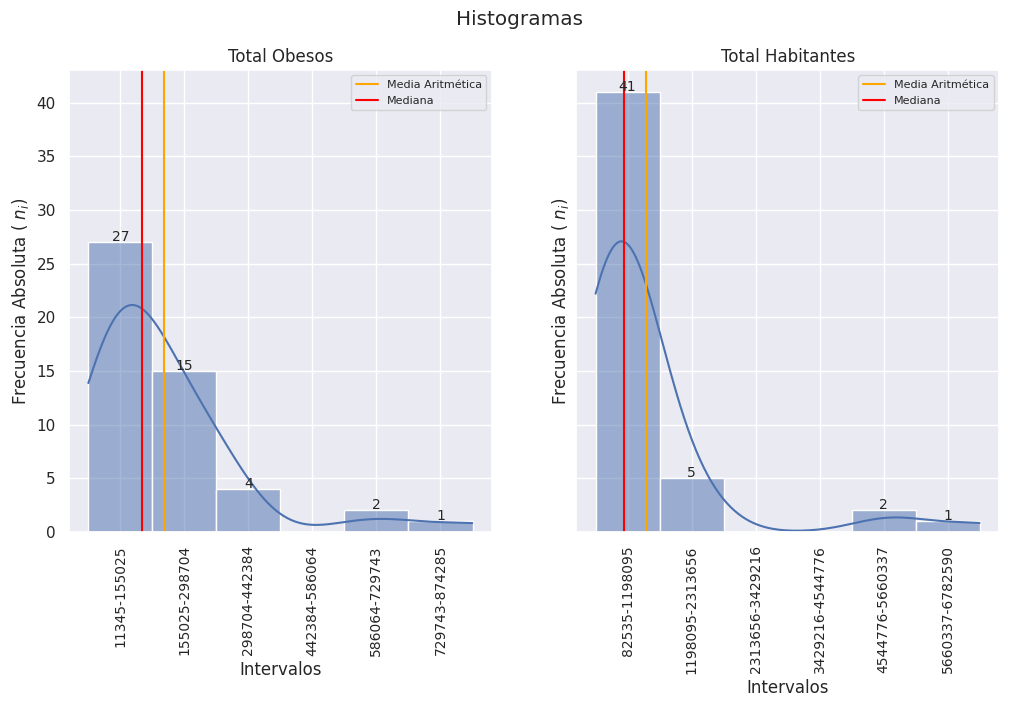

In [28]:
crear_histograma(DS_Obesidad, Estadisticos, variables)

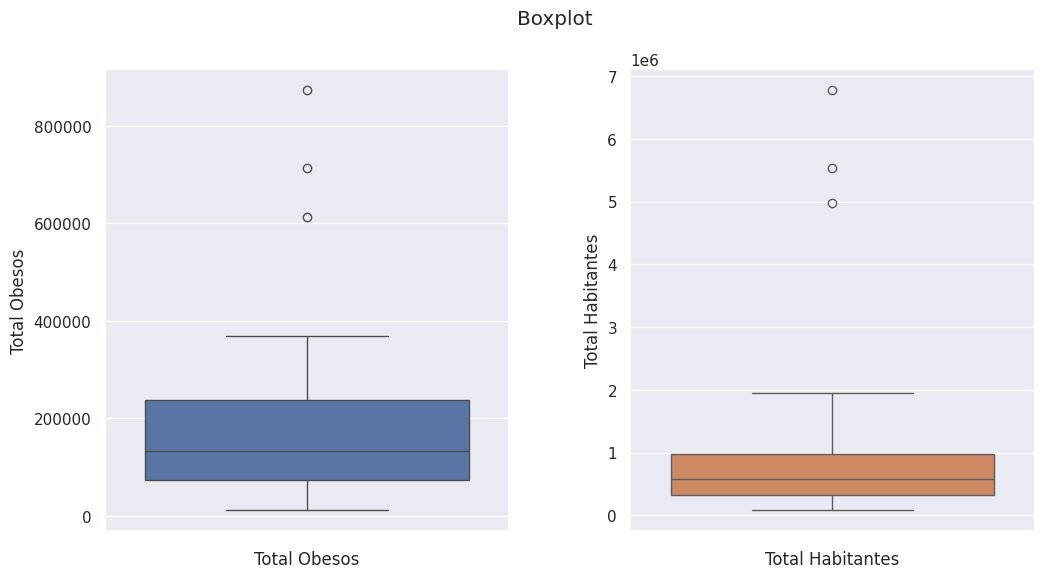

In [29]:
dic_outliers, boxplot  = crear_boxplot(DS_Obesidad, variables)

In [30]:
dic_outliers

{'Total Obesos': {'upper_out': {8: 712897, 28: 873423, 45: 612423},
  'lower_out': {}},
 'Total Habitantes': {'upper_out': {8: 5539567, 28: 6775897, 45: 4982789},
  'lower_out': {}}}

In [31]:
DS_Obesidad.iloc[[8,28,45]][['Provincia']+ variables]

,Provincia,Total Obesos,Total Habitantes
8,Barcelona,712897,5539567
28,Madrid,873423,6775897
45,Valencia,612423,4982789


In [32]:
DS_Obesidad.loc[DS_Obesidad['Total Obesos']==78423]

,Fecha,Provincia,Total Obesos,Total Habitantes,Cat_Total Obesos,Cat_Total Habitantes
26,2023-01-01,Lleida,78423,434789,"[11345.0, 155024.667)","[82535.0, 1198095.333)"
36,2023-01-01,La Rioja,78423,322567,"[11345.0, 155024.667)","[82535.0, 1198095.333)"


### Conclusiones del análisis Unidimensional

El CV es es la relación entre la desviación típica y su media aritmética. Como el CV es mayor a 80% en las dos variables, la media aritmética no es representativa del conjunto de datos y por lo tanto el conjunto de datos es heterogeneo.

El rango es la diferencia entre el mayor y el menor valor. En la variable total obesos tiene un valor de 862078 que es 75.99 veces su valor mínimo. En la variable total habitantes tiene un valor de 6693362 que es 81.1 veces el valor mínimo.

La varianza y el desvio estándar son muy sensibles a los valores extremos.

La variable Total Habitantes es multimodal. Llama la atención que la variable Total Obesos tenga el mismo valor para las provincias de La Rioja y Lleida.

El desvio estándar nos indica el grado de concentración de los datos alrededor de la media aritmetica. El desvio estándart de 168781.99 obesos para la variable Total Obesos y de 1311255.95  habitantes de la variable Total habitantes que respresentan el 92.16 % y el 136.7% de la media aritmética nos da un indicio que son variables con concentraciones bajas.

Como el coeficiente de Curtosis es positivo en ambas variables, las distribuciones son Leptocúrticas, es decir los valores están con más concentración en los valores centrales.

Como el Coeficiente de Asimetría de Fisher es positivo para ambas distribuciones lo que implica que la asimetría de ambas variables es positiva.

Como era de esperar se observan 3 outliers en cada una de las series que corresponden las provincias de Barcelona, Madrid y Valencia que son las provincias con mayor cantidad de habitantes. Como será realizado un análisis probabilistico los outliers no deberían tener incidencias.

**Se concluye que los datos son de una calidad adecuada para realizar el análisis probabilístico**

## Analizar

1. ¿Cuál es la probabilidad de padecer obesidad en España?. Se debe aportar su fórmula y su sustitución. Analizar los resultados obtenidos (15%)
2. Si seleccionamos una de las personas obesas al azar, ¿Cuál es la probabilidad de que resida en Barcelona? ¿Y en el resto de provincias? Se debe aportar su fórmula y su sustitución. (70%)
3. Aportar el árbol de decisión, añadir una explicación de cómo funciona, el resultado y un comentario o análisis del resultado obtenido. (15%)


### ¿Cuál es la probabilidad de padecer obesidad en España?. Se debe aportar su fórmula y su sustitución. Analizar los resultados obtenidos (15%)


El **espacio muestral**  es:


$$ \bbox[5px,border: 2px solid blue]{
S' = {(Alava, Obeso), (Alava, NoObeso),(Albacete, Obeso), (Albacete, NoObeso)..., (Barcelona, Obeso), (Barcelona, NoObeso), ....,(Zaragoza, Obeso), (Zaragoza, NoObeso)}
}  
 $$

Para los efectos de este práctico se considerará que la sumatoria de los datos de las provincias del dataset es igual al total de España



Para el cálculo de probabilidad de padecer obesidad en España lo resolveremos de fos formas distintas:

1.   Utilizando la definición de Probabilidad
2.   Utilizando el Teorema de la Probabilidad Total


#### 1. *Definición clásica de probabilidad*:

Si en un experimento aleatorio todos los sucesos elementales son equiprobables, **la probabilidad** de que se presente un determinado suceso **es igual al número de casos favorables a ese suceso dividido por el número total de casos posibles**.

$$ \bbox[5px,border: 2px solid blue]{
   P(A) = \frac{ \text{número de casos favorables} }{  \text{número de casos posibles} }  
} $$

luego

$$ \bbox[5px,border: 2px solid blue]{
   P(Obeso) = \frac{ \text{Total de Obesos} }{  \text{Total Habitantes} }  
} $$

Se calcula la cantidad todal de obesos y de habitantes de España como la suma de la cantidad de obesos y habitantes de todas las provincias del dataset.

In [33]:
DS_Obesidad_agg = pd.DataFrame(DS_Obesidad[variables].agg(sum)).T
DS_Obesidad_agg['P_Obeso']=np.round(DS_Obesidad_agg['Total Obesos']/DS_Obesidad_agg['Total Habitantes']*100,2)

In [34]:
DS_Obesidad_agg

,Total Obesos,Total Habitantes,P_Obeso
0,8918387,46787675,19.06


**La probabilidad de ser obeso en España es del 19.10%**

#### 1. *Teorema de la Probabilidad Total*

Para calcular la probabilidad de padecer obesidad en España, P(Obeso) utiliznado el Teorema de la **probabilidad total**, tenemos:

$$
P(Obeso) = \sum_{j=1}^n P(Prov_{j}) \cdot P(Obeso|Prov_{j}) $$

In [35]:
DS_Obesidad['P_Prov'] =(DS_Obesidad['Total Habitantes']/DS_Obesidad['Total Habitantes'].sum())
DS_Obesidad['P_Obeso_Prov'] =(DS_Obesidad['Total Obesos']/DS_Obesidad['Total Habitantes'])
P_Obeso =np.round(np.sum(DS_Obesidad['P_Prov']*DS_Obesidad['P_Obeso_Prov'])*100,2)
print( f' La probabilidad de ser obeso en España es:  {P_Obeso:.2f} %')


 La probabilidad de ser obeso en España es:  19.06 %


 y comprobamos que aplicando la definición de Probabilidad o el Teorema de la Probabilidad Total llegamos al mismo resultado, que es que **la probabilidad de ser obeso en España es 19.06 %**

### Si seleccionamos una de las personas obesas al azar, ¿Cuál es la probabilidad de que resida en Barcelona? ¿Y en el resto de provincias? Se debe aportar su fórmula y su sustitución. (70%)

Para el cálculo de probabilidad de que una persona obsea seleccionada al azar  resida en Barcelona utilizaremos dos aproximaciones


1.   Utilizando la definición de Probabilidad Condicional
2.   Utilizando el Teorema de la Probabilidad Total y Bayes


#### 1. *Resolución utilizando la definición de Probabilidad Condicional*

Estraemos del dataset los informaciones referidas a Barcelona y al total de España

In [36]:
DS_Obesidad.loc[DS_Obesidad['Provincia']=='Barcelona',['Provincia']+variables]

,Provincia,Total Obesos,Total Habitantes
8,Barcelona,712897,5539567


In [37]:
np.sum(DS_Obesidad[variables])

Total Obesos         8918387
Total Habitantes    46787675
dtype: int64

In [38]:
NoBarcelona = pd.DataFrame(np.sum(DS_Obesidad[DS_Obesidad['Provincia']!='Barcelona'][variables])).T
NoBarcelona['P_Obeso_Prov'] =(NoBarcelona['Total Obesos']/NoBarcelona['Total Habitantes'])
NoBarcelona

,Total Obesos,Total Habitantes,P_Obeso_Prov
0,8205490,41248108,0.19893


Para resolver este punto debemos calcular la **probabilidad condicionada de que la persona de Barcelona sea obsea** y se define como:

$$  \bbox[5px,border: 2px solid blue]{  
 P(Barcelona|_{Obeso}) = \frac{P( Barcelona \cap Obeso)}{ P(Obeso) }  \quad siendo \; P(Obeso) \neq 0
}  \\ $$

Para lo que se necesita calcular previamente:

$$ P(Obeso) = \frac{8918387}{46787675} = 0.1906\\ $$

$$ P( Barcelona \cap Obeso) = \frac{\text{casos posibles}}{\text{casos totales}} = \frac{712897}{46787675} = 0.0154\\ $$

Ahora, podemos sustituir los datos calculados:

$$ P(Barcelona|_{Obeso})  = \frac{0.0154}{0.1906}= 0.0799 $$

Para calcular en el resto de las provincias de ser obeso debemos
$$  \bbox[5px,border: 2px solid blue]{  
 P(NoBarcelona|_{Obeso}) = \frac{P( NoBarcelona \cap Obeso)}{ P(Obeso) }  \quad siendo \; P(Obeso \neq 0
}  \\ $$

$$ P(Obeso) = 0.1906\\ $$

$$ P( NoBarcelona \cap Obeso) = \frac{\text{casos posibles}}{\text{casos totales}} = \frac{8205490}{46787675} = 0.1754\\ $$

$$ P(Obeseo|_{NoBarcelona})  = \frac{0.1754}{0.1906}= 0.9201 $$



**Si seleccionamos una persona obesa al azar, la probabilidad que resida en Barcelona es de 7.99 % y que resida en el resto de las provicias es de 92.01%**

#### 2. *Resolución utilizando el Teorema de Bayes*

In [45]:
# Terorema de la Probabilidad Total - Probabilidad de ser obeso
P_Obeso =np.round(np.sum(DS_Obesidad['P_Prov']*DS_Obesidad['P_Obeso_Prov'])*100,2)
P_NoObeso = 1-P_Obeso

print ('Probabilidad de ser obeso en España es :', P_Obeso.round(2) , "%" )

Probabilidad de ser obeso en España es : 19.06 %


In [46]:
## Teorema de Bayes
Bar_PP=DS_Obesidad[DS_Obesidad['Provincia']=='Barcelona']['P_Prov'].values[0]
NoBar_PP= DS_Obesidad[DS_Obesidad['Provincia']!='Barcelona']['P_Prov'].sum()
Bar_Pobeso =DS_Obesidad[DS_Obesidad['Provincia']=='Barcelona']['P_Obeso_Prov'].values[0]
Bar_PNoobeso =1-Bar_Pobeso
NoBar_Pobeso =NoBarcelona['P_Obeso_Prov'].values[0]
NoBar_PNoobeso = 1-NoBar_Pobeso

P_Obeso_Bar = (Bar_PP*100*Bar_Pobeso)/P_Obeso
P_Obeso_NoBar = (NoBar_PP*100*NoBar_Pobeso)/P_Obeso
P_NoObeso_Bar = 1-P_Obeso_Bar
print ('Probabilidad de ser obeso en Barcelona es : ', (P_Obeso_Bar*100).round(4), '%' )
print ('Probabilidad de ser obeso en España desconsiderando Barcelona es : ', (P_Obeso_NoBar*100).round(4), '%' )


Probabilidad de ser obeso en Barcelona es :  7.9942 %
Probabilidad de ser obeso en España desconsiderando Barcelona es :  92.0132 %


Conclusión:

* Se ha verificado el cálculo aplicando los Teoremas de la Probabilidad Total y el de Bayes.

* **Si seleccionamos una persona obesa al azar, la probabilidad que resida en Barcelona es de  7.99 % y que resida en el resto de las provicias es de 92.01 %**


#### Arbol de decisión

Aprovechando las informaciones de la verificación realizada utilizando el Teorema de Bayes y el de la Probabilidad Total se representan los resultados obtenidos en el apartado utilizando un árbol de decisión

In [47]:
Mermaid ("""
graph LR;
    A[España]  -- Bacelona --> BAR(( """ +str(round(Bar_PP*100,2))+" %"+ """))
    BAR -- P_Obeso --> BAR_Obeso((""" +str(round(Bar_Pobeso*100,2))+" %"+"""))
    BAR -- P_NoObeso --> BAR_NoObeso((""" +str(round(Bar_PNoobeso*100,2))+" %"+"""))
    A[España]--No Barcelona --> NoBarcelona((""" +str(round(NoBar_PP*100,2))+" %"+"""))
    NoBarcelona -- P_Obeso --> NoBar_Pobeso((""" +str(round(NoBar_Pobeso*100,2))+" %"+"""))
    NoBarcelona -- P_NoObeso --> NoBar_NObeso((""" +str(round(NoBar_PNoobeso*100,2))+" %"+"""))

""" )

El árbol de decisión nos permite en forma ordenada representar las probabilidades de todos los eventos

### Aportar el árbol de decisión, añadir una explicación de cómo funciona, el resultado y un comentario o análisis del resultado obtenido. (15%)

Un árbol de decisión es una forma gráfica y analítica
de representar todos los eventos (sucesos) que
pueden surgir a partir de una decisión asumida en
cierto momento.

En este caso en particular el primer nodo estará representado por cada una de las 50 provincas de España que conforman el espacio muestral. En el primer nodo de probabilidad se representa la probabilidad de que un individuo perteneza a esa provincia.

A partir de cada nodo de probabilidad surgen dos ramas, cada ramificación indica un posible resultado, en este caso si es o no obeso y se representan dos nodos de probabilidad con los resultados.






In [48]:
esquema = """ graph LR;"""
dic_Pobeso ={}
for prov in DS_Obesidad['Provincia'].unique():
    Codprov = prov.replace(" ", "")
    PP=DS_Obesidad[DS_Obesidad['Provincia']==prov]['P_Prov'].values[0]
    Pobeso =DS_Obesidad[DS_Obesidad['Provincia']== prov]['P_Obeso_Prov'].values[0]
    PNoobeso =1-Pobeso
    esqProv = """A[España]  --"" """ + prov +""" --> """ + Codprov + """(( """ +str(round(PP*100,2))+" %"+ """))\n"""
    esqP = Codprov + """ -- P_Obeso --> """ + Codprov + """_Obeso((""" +str(round(Pobeso*100,2))+" %"+"""))\n"""
    esqNP = Codprov + """ -- P_NoObeso --> """ + Codprov + """_NoObeso((""" +str(round(PNoobeso*100,2))+" %"+"""))\n"""
    esquema = esquema +esqProv+esqP+esqNP
    dic_Pobeso[prov] ={}
    dic_Pobeso[prov]['PP'] =PP
    dic_Pobeso[prov]['Pobeso'] =Pobeso
    dic_Pobeso[prov]['PNoobeso'] =PNoobeso

Mermaid (esquema)

La representación del árbol de todas las provincias de España pierde un poco de claridad debido a su gran tamaño.
Calculamos las probabilidades por provincia utilizando el Teorema de Bayes

In [49]:
## Se aplica el teorema de bayes a todas las provincias y
## calculamos la probabilidad de que una persona obesa al azar resida en cada provincia
DS_Pobeso =pd.DataFrame.from_dict(dic_Pobeso).T
P_Obeso=np.sum(DS_Pobeso['PP']*DS_Pobeso['Pobeso'])
DS_Pobeso['P_Obeso_Porv'] = DS_Pobeso['PP']*DS_Pobeso['Pobeso']/P_Obeso

In [50]:
DS_Pobeso.P_Obeso_Porv.sort_values(ascending = False)*100

Madrid                    9.793509
Barcelona                 7.993564
Valencia                  6.866970
Alicante                  4.131050
Murcia                    3.716176
Baleares                  3.616876
Málaga                    3.501014
Sevilla                   3.310397
Coruña                    3.222814
Asturias                  3.119779
Cádiz                     2.757191
Almería                   2.697427
Bizkaia                   2.672512
Granada                   2.503076
Santa Cruz de Tenerife    2.403405
Córdoba                   2.385958
Badajoz                   2.256395
Zaragoza                  2.067022
Jaén                      1.858957
Ciudad Real               1.821215
Cantabria                 1.786702
Guipúzcoa                 1.742725
Albacete                  1.639691
Castellón                 1.623489
Cáceres                   1.486446
Tarragona                 1.484831
León                      1.394254
Toledo                    1.383916
Lugo                

**Conclusión**

Un árbol de decisión nos permite de forma gráfica y analítica
de representar todos los eventos que pueden surgir a partir de una decisión asumida en cierto momento.

Es muy útil ya que permite calcular rápidamente:
1. las Probabilidades Condicionadas utilizando el Teorema de Bayes y
2. las Probabilidades de un suceso utilizando el Teorema de la Probabilidad Total.

Realizar las soluciones de los apartados 1 y 2 utilizando dos aproximaciones diferentes me permitió terminar de entender al Teorema de Bayes y de Probabilidad Total.